<p>In this notebook, we introduce how to query the anotation database and give a flavor of how to use the results to do some simple analysis. By the end, you should be able to query for neurons, query for synapses between those neurons, and visualize the neurons and synapes.

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Background</h2>


This dataset is part of a collaboration between the Lee Lab at Harvard University and the Tuthill Lab at the University of Washington. Before beginning on this tutorial, please make sure you have completed the onboarding instructions which can be found [here](https://docs.google.com/document/d/10fnQHWTPluKeNXko6C63iKTKVwqXeSEQ10ftYgtEfhc/edit)

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Local setup instructions</h2>

<p>
To query and visualize the data, you will need a few custom packages developed by the Allen Institute and Princeton University.  If you want to setup your local computer's python system to use these packages you'll need to install them and their dependancies. 
</p>

<p>
The easiest way to install is to use Anaconda python.  Open up a terminal, or a command prompt on windows.  Navigate to the directory where you have checked out the swdb_2021 repository. Activate a conda environment if you'd like then type..

</div>
<h4>Linux/OSX</h4>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
./scripts/em_conda_install.sh
</div>
<h4>Windows</h4>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
./scripts/em_conda_install.bat
</div>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
You'll need to restart your kernel after you do the install
</div>




<h2>3D Visualization Methods </h2>

EM data involves high resolution reconstructions of neurons, and so visualizing them interatively in 3D is essential to understanding the data (plus it's just fun).  This requires use of more specialized plotting packages than matplotlib.  There are a few options that have different plusses and minuses that are summarized below.  We'll show you code snippets from all methods, but execute the one based upon the viz_method variable defined in the next cell.
<table>
    <tr>
        <td><h3>viz_method</h3></td>
        <td><h3>pros</h3></td>
        <td><h3>cons</h3></td>
    </tr>
    <tr>
        <td>
           vtk
        </td>
        <td>Fastest <br/>
            Most features: <br/>
            mesh coloring<br/>  
            programatic camera control<br/>
            programatic saving<br/>
            extensible</td>
        <td> Requires local installation <br/>(no AWS possible)</td>
    </tr>
    <tr>
        <td> itkwidgets</td>
        <td> fastest notebook widget <br/>
             easy screen shot <br/>
             bug free <br/>
             aws compatible <br/>
        </td>
        <td>
        no programatic camera control<br/>
        no advanced mesh coloring
        </td> 
    </tr>    
    </table>

In [1]:
import os

# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'itkwidgets'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import the key modules</h2>
Our analysis workflows use a couple of special purpose packages we have developed. Here, we are going to look at the CAVEclient (Connectome Annotation Versioning Engine), a package that quickly performs simple analysis queries and produces tidy Pandas dataframes.
</div>

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import some of our favorite modules</h2>
Our analysis workflows makes use of many of the common scientific computing packages like Numpy and Pandas.
</div>

In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Setting up a CAVE account </h2>

CAVE is the Connectome Annotation Versioning Engine.
It is a collection of services which manage proofreading and data annotation for large scale connectomics dataset.
These services were developed during the IARPA MICrONS program, but now support data from several projects including FANC and FlyWire.  You need to have an account on CAVE to use its services.


To get an account please first go to this [website](https://cave.fanc-fly.com/materialize/views/datastack/fanc_production_mar2021)

You should be prompted to login with a google account and then you must seperately accept the terms and conditions.

Once you have registered, you need to get access to the dataset. If you have not already, please complete the [onboarding instructions](https://docs.google.com/document/d/10fnQHWTPluKeNXko6C63iKTKVwqXeSEQ10ftYgtEfhc/edit) of for using FANC. Once you have done so, please reach out to one of the following people with your email address to get access to the dataset:
   
* Jasper Phelps (jtmaniatesselvin@g.harvard.edu)
* Brandon Mark (bmark89@uw.edu)
* John Tuthill (tuthill@uw.edu)
* Wei-Chung Lee (wei-chung_lee@hms.harvard.edu)
 
Once you have an account and have access to the FANC dataset, you can then follow along this notebook.
This notebook will show you how to get a programatic token that you can use to authenticate to the services in order to make queries. The token can then be used on different computers.

<h2>Setting key parameters </h2>
Every combination of image and segmentation data we call a 'datastack', since a dataset might have multiple such 'datastacks' associated with it.  The female ventral nerve cord that we are going to use is called `fanc_v4` named because....
</div>


In [4]:
client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

In [5]:
# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="8833c784fa3bb12d3685185ce4ee28aa", overwrite=True)

# then comment or delete the line as you don't need to run it on this computer  again

In [5]:
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Terms of Service Error</h2>
If for some reason you are getting an error that says you haven't signed the terms of service, visit this link.

<a href="https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept"> Microns Public TOS </a>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Client Basics</h2>
The client lets you connect to a number of different services, and you can read about all of them in  <a href="https://caveclient.readthedocs.io/">the CAVEclient documentation</a>

For this notebook however we will focus on the 'materialize' client which lets you access tables of annotations on the data, including cells, nuclei and synapses. 

To see what tables are available, use the 'get_tables' method.
</div>

In [6]:
client.materialize.get_tables()

['motor_neuron_table_v6',
 't1_leg_motor_neurons',
 'mn_classifications',
 't1_leg_motor_neuron_classifications',
 'sensory_axon_table',
 'motor_neuron_table',
 'motor_neuron_table_v2',
 'nuclei_aug2021ver2',
 'nuclei_aug2021',
 'soma_aug2021',
 'soma_aug2021_test',
 'test_soma',
 'soma_jan2022',
 'hair_plate_table',
 'motor_neuron_table_v4',
 'synapses_jan2022',
 'nerve_bundle_fibers_v0',
 'bristle_axon_table',
 'downstream_bristle_table_v0',
 'motor_neuron_table_v5',
 'hemilineage_table',
 'motor_neuron_table_v7']

In [7]:
# For each table you can get metadata about that table
client.materialize.get_table_metadata('soma_aug2021')

{'aligned_volume': 'fanc_v4',
 'id': 37,
 'valid': True,
 'table_name': 'soma_aug2021',
 'created': '2021-08-30T06:58:45.696837',
 'schema': 'nucleus_detection',
 'description': 'IDs shared with nuclei_aug2021. Based on nuclei segmentation at precomputed://gs://ng_scratch_ranl_zetta_30/vnc1_full_v3align_2/realigned_v1/seg/84214f67075692a9e41c02d164b466ba',
 'flat_segmentation_source': None,
 'schema_type': 'nucleus_detection',
 'user_id': '1335',
 'reference_table': None,
 'voxel_resolution': [4.3, 4.3, 45.0]}

In [8]:
# and how many annotations are in it
# the maybe most important table is the synapse table (synapses_pni_2)
# which has >330 million synapses, so querying its length takes a long time
client.materialize.get_annotation_count('soma_aug2021')


14679

In [9]:
# lets look at the soma table
# if you ask for the whole thing, the client will give you the first 200K rows
# which is good enough to cover everything other than synapses
soma_df= client.materialize.query_table('soma_aug2021')
soma_df.head()

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,73046055192626269,t,NaN,74034585067113699,648518346520480566,"[59040, 198704, 843]","[nan, nan, nan]","[nan, nan, nan]"
1,72623018026730718,t,NaN,73188442015930082,648518346493817486,"[33920, 148064, 564]","[nan, nan, nan]","[nan, nan, nan]"
2,72129749958263060,t,NaN,72272343342337235,648518346491452007,"[7984, 109312, 1880]","[nan, nan, nan]","[nan, nan, nan]"
3,72129818677740891,t,NaN,72272343409587917,648518346382273397,"[7248, 109680, 2013]","[nan, nan, nan]","[nan, nan, nan]"
4,72129956116693029,t,NaN,72272686939967070,648518346491600145,"[6224, 119888, 1831]","[nan, nan, nan]","[nan, nan, nan]"


In [10]:
# remember that you can check the metadata if you're unsure what is in the table
client.materialize.get_table_metadata('soma_aug2021')['description']

'IDs shared with nuclei_aug2021. Based on nuclei segmentation at precomputed://gs://ng_scratch_ranl_zetta_30/vnc1_full_v3align_2/realigned_v1/seg/84214f67075692a9e41c02d164b466ba'

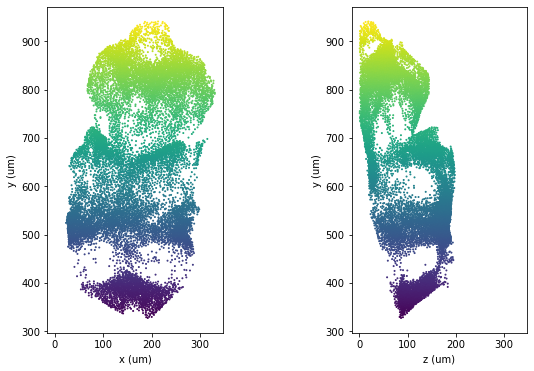

In [11]:
# useful function for converting a pandas data frame voxel position
# column to a np.array of Nx3 size in nm
def convert_to_nm(col, voxel_size=[4.3,4.3,45]):
    return np.vstack(col.values)*voxel_size

# function to plot a dataframe
def plot_soma_loc(df, ax, x=0, y=1, c='r', s=10, cmap=None):
    
    # convert the position to microns
    pos = convert_to_nm(df['pt_position'])/1000
    
    if cmap:
        c = pos[:,y]
        ax.scatter(pos[:,x], pos[:,y], c=c, s=s)
    # plot two dimensions as a scatterplot
    else:
        ax.scatter(pos[:,x], pos[:,y], c=c, s=s)

# make a new axis with two subplots
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1)

# plot each soma
plot_soma_loc(soma_df, ax1, cmap='viridis', s=1)
#plot_soma_loc(ext_axon_df, ax1, c='r')


# label some axis, make x,y scaling same
ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
# to keep the pia 'up'
#ax1.set_ylim(1100,300)
ax1.set_aspect('equal')

# plot the same thing as x,z
plot_soma_loc(soma_df, ax2, x=2, y=1, cmap='viridis', s=1)
#plot_soma_loc(ext_axon_df, ax2, x=0, y=2, c='r')

ax2.set_xlabel('z (um)')
ax2.set_ylabel('y (um)')
ax2.set_aspect('equal')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Querying for synapses</h2>
Let's pick out a cell ID of a tibia extensor motor neuron and then find all the synapses onto that neuron</div>


In [12]:
motor_neuron = 648518346503975976 #fast extensor
motor_neuron

648518346503975976

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we are ready to query synapses for this neuron. Because the analysis database can, in principle, handle multiple different sources of synapses, we have to specify which synapse table we want to use. The current table holding the most up to date automated synapse detection is called `synapses_may2021`.  The "info" service has this information however, so we don't need to remember it.

Because synapses are such a common query, there is a wrapper method `synapse_query` which makes uses the default synapse table and simplifies the syntax. So, we can specify which synapses we get back from the table by setting the `post_ids` argument to a list of IDs, which makes a query that only returns synapses whose postsynaptic id is the one selected.  You can also filter by `pre_ids` which will do the same for the pre-synaptic side. Setting this will only return synapses that are from certain neurons.  Setting both `pre_ids` and `post_ids` will return only synapses that are from the `pre_ids` onto the `post_ids`.
</div>

In [13]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(15070, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,514768,t,72412875343587877,648518346484015645,72412875343616567,648518346503975976,38,"[11707, 104227, 3132]","[11711, 104249, 3134]"
1,996302,t,73045918693693536,648518346483672751,73045918693702920,648518346503975976,55,"[29855, 95999, 2299]","[29867, 95971, 2299]"
2,1010533,t,72694349380756311,648518346499825475,72694349380749035,648518346503975976,28,"[20045, 103653, 1353]","[20077, 103639, 1353]"
3,1551033,t,72764443783883040,648518346520471350,72764443783885596,648518346503975976,38,"[21967, 95279, 2353]","[21993, 95259, 2353]"
4,1724297,t,73116768339967504,648518346475470772,73116768339973085,648518346503975976,22,"[30837, 109053, 2033]","[30873, 109055, 2034]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Synapse Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>the ID of the cell on the presynaptic side</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>score</td>
        <td>The size of the synaptic cleft in units of 4.3,4.3,45 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse (in voxels) </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>

</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in this table is a single synapse. You should see that the value in the post_pt_root_id column is the same for all, and equals the id you selected above. 
<h5>Note again that position columns are in voxel coordinates, just like Neuroglancer displays in the upper left corner. A single voxel has dimensions 4.3x4.3x45 nm.</h5>
</div>

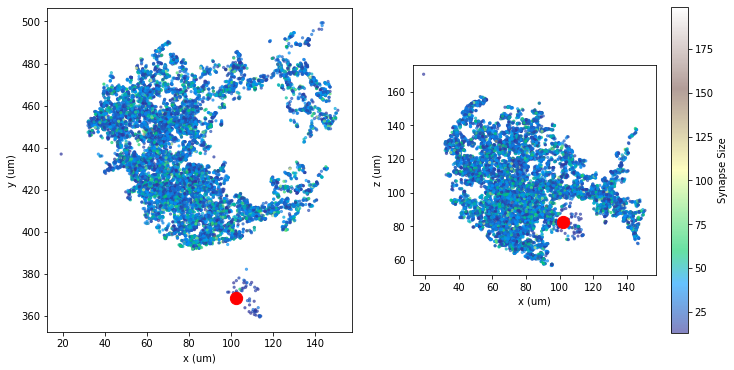

In [14]:
# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = convert_to_nm(post_synapse_df.post_pt_position)
# and plot their positions in x,y along with the soma position as a red circle
f ,ax =plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,1]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[0].scatter([soma_pos[0,0]/1000],[soma_pos[0,1]/1000],c='r',s=150)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('y (um)')


m =ax[1].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,2]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[1].scatter([soma_pos[0,0]/1000],[soma_pos[0,2]/1000],c='r',s=150)
ax[1].set_aspect('equal')
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')
f.colorbar(m, label='Synapse Size')

In [15]:
# pandas groupby to count number of synapses from different neurons
# followed by transform to label the individual synapses with 
# how many other synapses are in that connection.

# transform labels all the rows in the group with the result of this function on the group
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
# save this result in a new colum
post_synapse_df['syn_in_conn']=syn_in_conn
syn_conn_fast_extensor= post_synapse_df[['id', 'pre_pt_root_id', 'score','syn_in_conn']].sort_values('syn_in_conn', ascending=False)
syn_real_conn_fast_extensor =syn_conn_fast_extensor[syn_conn_fast_extensor.syn_in_conn >= 3] # exlcude the ones that only show one or two synapses

premotor_analysis_fast_extensor = syn_real_conn_fast_extensor.drop_duplicates(subset=['pre_pt_root_id'], keep='first')
premotor_analysis_fast_extensor # unique pre_pt_root_id for the fast extensor

,id,pre_pt_root_id,score,syn_in_conn
5035,20251863,648518346509908006,13,568
10158,9533371,648518346482615849,13,466
2553,25499746,648518346483672751,39,435
6302,15097276,648518346472979044,40,357
5580,10853014,648518346490338058,27,269
...,...,...,...,...
13327,18460574,648518346489868466,31,3
5793,47137921,648518346508764887,20,3
11726,48556788,648518346482170917,44,3
1973,41622081,648518346486481941,49,3


In [16]:
# find the neuron with the most synapses
max_input_idx = post_synapse_df.syn_in_conn.idxmax()
max_input_neuron = post_synapse_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# the shape of this synapse table will tell us how many synapses are made by this prem
post_synapse_df[post_synapse_df.pre_pt_root_id == max_input_neuron].shape

648518346509908006


(568, 10)

In [17]:
motor_neuron = 648518346517427492 #slow extensor
motor_neuron

648518346517427492

In [18]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(7847, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,1498238,t,72834812662492241,648518346490338058,72834812662469376,648518346517427492,38,"[23857, 94289, 2680]","[23885, 94279, 2680]"
1,1679911,t,72764581625625591,648518346488950249,72764581625638209,648518346517427492,30,"[20833, 99799, 3172]","[20813, 99777, 3174]"
2,3399633,t,72483380855639631,648518346504381420,72483380855635084,648518346517427492,63,"[13725, 108445, 1849]","[13739, 108415, 1849]"
3,4319807,t,72412944197260723,648518346491527080,72412944197253914,648518346517427492,13,"[11233, 106355, 3383]","[11269, 106365, 3383]"
4,5107243,t,72834743942890967,648518346490280970,72834743942888658,648518346517427492,27,"[22587, 93983, 2645]","[22563, 93993, 2646]"


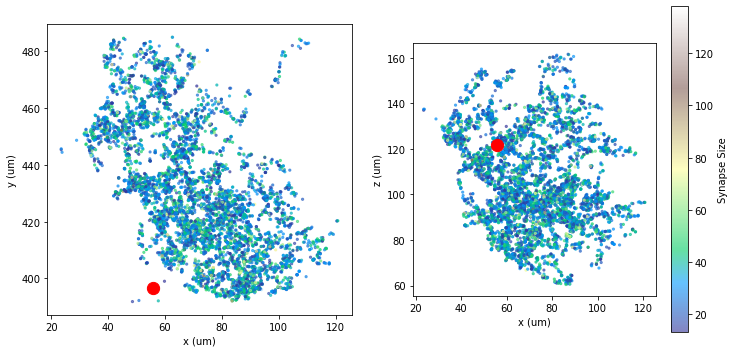

In [19]:
# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = convert_to_nm(post_synapse_df.post_pt_position)
# and plot their positions in x,y along with the soma position as a red circle
f ,ax =plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,1]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[0].scatter([soma_pos[0,0]/1000],[soma_pos[0,1]/1000],c='r',s=150)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('y (um)')

m =ax[1].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,2]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[1].scatter([soma_pos[0,0]/1000],[soma_pos[0,2]/1000],c='r',s=150)
ax[1].set_aspect('equal')
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')
f.colorbar(m, label='Synapse Size')

In [20]:
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
post_synapse_df['syn_in_conn']=syn_in_conn
syn_conn_slow_extensor= post_synapse_df[['id', 'pre_pt_root_id', 'score','syn_in_conn']].sort_values('syn_in_conn', ascending=False)
syn_real_conn_slow_extensor=syn_conn_slow_extensor[syn_conn_slow_extensor.syn_in_conn >= 3]

premotor_analysis_slow_extensor = syn_real_conn_slow_extensor.drop_duplicates(subset=['pre_pt_root_id'], keep='first')
premotor_analysis_slow_extensor

,id,pre_pt_root_id,score,syn_in_conn
1037,40280110,648518346509908006,33,332
4662,10923677,648518346482615849,41,266
3648,43052441,648518346517696104,26,192
4042,41220771,648518346499337822,32,190
311,45922810,648518346483672751,17,189
...,...,...,...,...
7097,22291515,648518346490657778,27,3
6973,32276017,648518346515027783,36,3
3698,36336043,648518346497043749,28,3
3657,3666110,648518346476305463,30,3


In [21]:
# find the neuron with the most synapses
max_input_idx = post_synapse_df.syn_in_conn.idxmax()
max_input_neuron = post_synapse_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# the shape of this synapse table will tell us how many synapses are made by this prem
post_synapse_df[post_synapse_df.pre_pt_root_id == max_input_neuron].shape

648518346509908006


(332, 10)

In [22]:
motor_neuron = 648518346482643497 #fast flexor, main_tibia_flexor_in_femur_5
motor_neuron

648518346482643497

In [23]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(11296, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,7747,t,72483312069030716,648518346503905742,72483312069030730,648518346482643497,17,"[13655, 105855, 1713]","[13627, 105845, 1714]"
1,477300,t,72483518227628514,648518346517626216,72483518227607031,648518346482643497,16,"[14063, 110881, 1786]","[14051, 110913, 1786]"
2,1690531,t,72835018820898505,648518346513865497,72835018820898552,648518346482643497,13,"[23905, 100689, 2679]","[23897, 100733, 2680]"
3,2539099,t,72413081032441746,648518346489444204,72413081032433286,648518346482643497,17,"[11051, 110275, 2306]","[11077, 110297, 2306]"
4,3000704,t,72553543777042041,648518346520505142,72553543777047507,648518346482643497,32,"[16243, 100885, 2526]","[16215, 100901, 2526]"


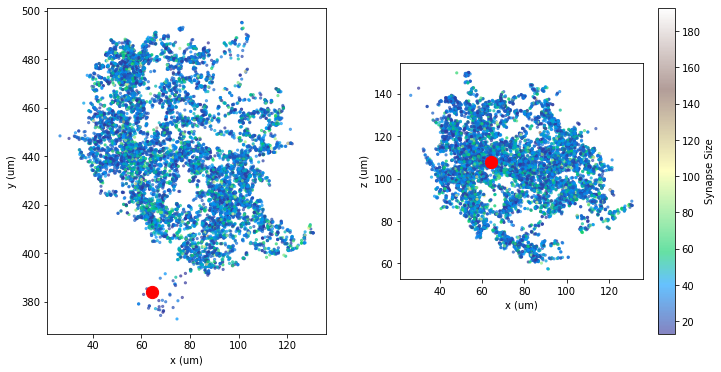

In [24]:
# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = convert_to_nm(post_synapse_df.post_pt_position)
# and plot their positions in x,y along with the soma position as a red circle
f ,ax =plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,1]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[0].scatter([soma_pos[0,0]/1000],[soma_pos[0,1]/1000],c='r',s=150)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('y (um)')

m =ax[1].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,2]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[1].scatter([soma_pos[0,0]/1000],[soma_pos[0,2]/1000],c='r',s=150)
ax[1].set_aspect('equal')
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')
f.colorbar(m, label='Synapse Size')

In [25]:
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
post_synapse_df['syn_in_conn']=syn_in_conn
syn_conn_fast_flexor= post_synapse_df[['id', 'pre_pt_root_id', 'score','syn_in_conn']].sort_values('syn_in_conn', ascending=False)
syn_real_conn_fast_flexor=syn_conn_fast_flexor[syn_conn_fast_flexor.syn_in_conn >= 3]

premotor_analysis_fast_flexor = syn_real_conn_fast_flexor.drop_duplicates(subset=['pre_pt_root_id'], keep='first')
premotor_analysis_fast_flexor

,id,pre_pt_root_id,score,syn_in_conn
3018,48607276,648518346486706585,39,536
4698,35402862,648518346485385491,14,355
5881,35443653,648518346482618153,16,314
4,3000704,648518346520505142,32,309
1920,26007898,648518346489444204,20,277
...,...,...,...,...
541,12856839,648518346494486443,31,3
4654,8346349,648518346487394837,18,3
11552,40083227,648518346520397015,21,3
7514,32006832,648518346489402901,35,3


In [26]:
# find the neuron with the most synapses
max_input_idx = post_synapse_df.syn_in_conn.idxmax()
max_input_neuron = post_synapse_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# the shape of this synapse table will tell us how many synapses are made by this prem
post_synapse_df[post_synapse_df.pre_pt_root_id == max_input_neuron].shape

648518346486706585


(536, 10)

In [27]:
motor_neuron = 648518346491928082 #intermediate flexor, main_tibia_flexor_in_femur_3
motor_neuron

648518346491928082

In [28]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(9424, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,358629,t,72412806490079235,648518346476953544,72412806490054980,648518346491928082,24,"[10731, 101499, 2938]","[10723, 101531, 2939]"
1,1078993,t,72694212478951326,648518346479348578,72694212478950952,648518346491928082,33,"[18713, 99751, 2440]","[18747, 99731, 2441]"
2,3526491,t,72834950101325613,648518346492622267,72834950101320834,648518346491928082,19,"[23875, 100309, 2638]","[23887, 100345, 2639]"
3,3547037,t,73046537101660939,648518346489698355,73046537101656135,648518346491928082,38,"[29723, 113029, 2084]","[29751, 113015, 2085]"
4,3708166,t,72905524802665323,648518346479178641,72905524802672528,648518346491928082,17,"[26255, 105271, 2288]","[26291, 105269, 2289]"


In [29]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(9424, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,358629,t,72412806490079235,648518346476953544,72412806490054980,648518346491928082,24,"[10731, 101499, 2938]","[10723, 101531, 2939]"
1,1078993,t,72694212478951326,648518346479348578,72694212478950952,648518346491928082,33,"[18713, 99751, 2440]","[18747, 99731, 2441]"
2,3526491,t,72834950101325613,648518346492622267,72834950101320834,648518346491928082,19,"[23875, 100309, 2638]","[23887, 100345, 2639]"
3,3547037,t,73046537101660939,648518346489698355,73046537101656135,648518346491928082,38,"[29723, 113029, 2084]","[29751, 113015, 2085]"
4,3708166,t,72905524802665323,648518346479178641,72905524802672528,648518346491928082,17,"[26255, 105271, 2288]","[26291, 105269, 2289]"


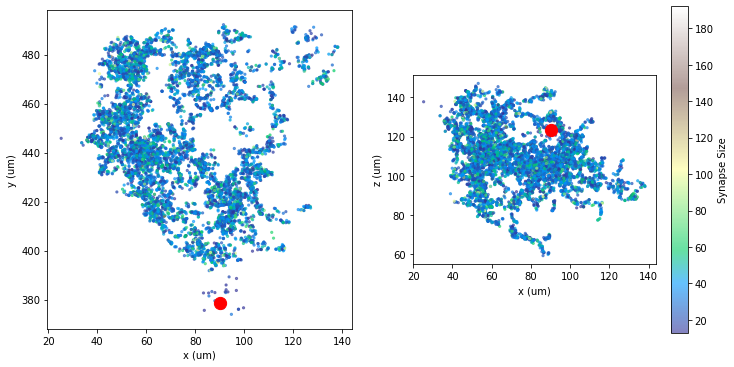

In [30]:
# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = convert_to_nm(post_synapse_df.post_pt_position)
# and plot their positions in x,y along with the soma position as a red circle
f ,ax =plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,1]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[0].scatter([soma_pos[0,0]/1000],[soma_pos[0,1]/1000],c='r',s=150)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('y (um)')


m =ax[1].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,2]/1000, alpha=0.6, s=5, c=post_synapse_df.score, cmap='terrain')

# add the soma position as a red circle
soma_pos = convert_to_nm(soma_df.pt_position[soma_df.pt_root_id == motor_neuron])
ax[1].scatter([soma_pos[0,0]/1000],[soma_pos[0,2]/1000],c='r',s=150)
ax[1].set_aspect('equal')
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')
f.colorbar(m, label='Synapse Size')

In [32]:
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
post_synapse_df['syn_in_conn']=syn_in_conn
syn_conn_intermediate_flexor= post_synapse_df[['id', 'pre_pt_root_id', 'score','syn_in_conn']].sort_values('syn_in_conn', ascending=False)
syn_real_conn_intermediate_flexor=syn_conn_intermediate_flexor[syn_conn_intermediate_flexor.syn_in_conn >= 3]

premotor_analysis_intermediate_flexor = syn_real_conn_intermediate_flexor.drop_duplicates(subset=['pre_pt_root_id'], keep='first')
premotor_analysis_intermediate_flexor

,id,pre_pt_root_id,score,syn_in_conn
2669,5053898,648518346486706585,44,440
9056,26831232,648518346520505142,67,286
6825,15054628,648518346482618153,58,246
6614,17826459,648518346472212018,13,208
5174,7321862,648518346490939256,27,180
...,...,...,...,...
7806,9440394,648518346526182103,52,3
5450,42310768,648518346480700381,21,3
1367,29680810,648518346476974556,23,3
793,1551254,648518346491445623,51,3


In [33]:
# find the neuron with the most synapses
max_input_idx = post_synapse_df.syn_in_conn.idxmax()
max_input_neuron = post_synapse_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

post_synapse_df[post_synapse_df.pre_pt_root_id == max_input_neuron].shape

648518346486706585


(440, 10)

In [36]:
motor_neuron = 648518346502852851 #auxiliary_tibia_flexor_in_femur_Bslow 
motor_neuron

648518346502852851

In [37]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = motor_neuron)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(376, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,22899364,t,72413149684866223,648518346490346506,72413149684866826,648518346502852851,47,"[10737, 111599, 2181]","[10749, 111639, 2182]"
1,29758194,t,72553475057131213,648518346465912624,72553475057270729,648518346502852851,18,"[14765, 98509, 2447]","[14775, 98523, 2445]"
2,30268215,t,72764375131446258,648518346490346506,72764375131453462,648518346502852851,49,"[21233, 94011, 2452]","[21203, 94023, 2453]"
3,8440978,t,72412806557184800,648518346494790578,72412806557178172,648518346502852851,13,"[10753, 101735, 3065]","[10773, 101737, 3067]"
4,3715299,t,72413081166481102,648518346479324370,72413081166483555,648518346502852851,39,"[10605, 110009, 2491]","[10599, 110013, 2494]"


In [48]:
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
post_synapse_df['syn_in_conn']=syn_in_conn
syn_conn_slow_flexor= post_synapse_df[['id', 'pre_pt_root_id', 'score','syn_in_conn']].sort_values('syn_in_conn', ascending=False)
syn_real_conn_slow_flexor=syn_conn_slow_flexor[syn_conn_slow_flexor.syn_in_conn >= 3]

premotor_analysis_slow_flexor = syn_real_conn_slow_flexor.drop_duplicates(subset=['pre_pt_root_id'], keep='first')
premotor_analysis_slow_flexor

,id,pre_pt_root_id,score,syn_in_conn
85,1007777,648518346472212018,27,19
335,24342893,648518346479324370,35,19
99,4767838,648518346489630412,28,17
43,27569753,648518346520505142,25,12
21,27785077,648518346475198776,18,10
39,42627745,648518346479321810,13,9
256,3000200,648518346486600239,29,8
54,35307294,648518346476953544,21,8
246,14660731,648518346500760937,22,8
334,6123114,648518346485385491,18,8


In [39]:
max_input_idx = post_synapse_df.syn_in_conn.idxmax()
max_input_neuron = post_synapse_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

post_synapse_df[post_synapse_df.pre_pt_root_id == max_input_neuron].shape

648518346479324370


(19, 10)

In [40]:
# Find the common inputs (premotor neurons) based on the same pre_pt_root_id for fast extensor and flexor 
common_input_fast_ext_fle = pd.merge(premotor_analysis_fast_extensor, premotor_analysis_fast_flexor, how ='inner', on =['pre_pt_root_id'])
common_input_fast_ext_fle

,id_x,pre_pt_root_id,score_x,syn_in_conn_x,id_y,score_y,syn_in_conn_y
0,20251863,648518346509908006,13,568,44059519,33,5
1,10853014,648518346490338058,27,269,40837226,42,4
2,44539649,648518346517696104,47,268,5476099,29,4
3,43588092,648518346484015645,36,248,30222295,56,6
4,138853,648518346490332764,27,222,21793137,20,3
...,...,...,...,...,...,...,...
81,613603,648518346475198776,52,3,43424477,29,11
82,5388531,648518346496642562,15,3,30413692,13,36
83,30465471,648518346494036727,57,3,47785714,28,7
84,11233456,648518346490021073,14,3,20030669,13,18


In [41]:
# Find the distinct inputs (premotor neurons) for the fast extensor
premotor_distinct_fast_extensor= premotor_analysis_fast_extensor[~premotor_analysis_fast_extensor["pre_pt_root_id"].isin(common_input_fast_ext_fle.pre_pt_root_id)]
premotor_distinct_fast_extensor

,id,pre_pt_root_id,score,syn_in_conn
10158,9533371,648518346482615849,13,466
2553,25499746,648518346483672751,39,435
6302,15097276,648518346472979044,40,357
2907,24182632,648518346512137518,31,235
3377,33082696,648518346485838974,27,202
...,...,...,...,...
13327,18460574,648518346489868466,31,3
5793,47137921,648518346508764887,20,3
11726,48556788,648518346482170917,44,3
1973,41622081,648518346486481941,49,3


In [42]:
# Find the distinct inputs (premotor neurons) for the fast flexor
premotor_distinct_fast_fle= premotor_analysis_fast_flexor[~premotor_analysis_fast_flexor["pre_pt_root_id"].isin(common_input_fast_ext_fle.pre_pt_root_id)]
premotor_distinct_fast_fle

,id,pre_pt_root_id,score,syn_in_conn
3018,48607276,648518346486706585,39,536
5881,35443653,648518346482618153,16,314
4,3000704,648518346520505142,32,309
2926,33625694,648518346476953544,25,161
7939,40768890,648518346488438921,30,136
...,...,...,...,...
541,12856839,648518346494486443,31,3
4654,8346349,648518346487394837,18,3
11552,40083227,648518346520397015,21,3
7514,32006832,648518346489402901,35,3


In [43]:
# Find the common inputs (premotor neurons) based on the same pre_pt_root_id for slow extensor and flexor 
common_input_slow_ext_fle = pd.merge(premotor_analysis_slow_extensor, premotor_analysis_slow_flexor, how ='inner', on =['pre_pt_root_id'])
common_input_slow_ext_fle

,id_x,pre_pt_root_id,score_x,syn_in_conn_x,id_y,score_y,syn_in_conn_y
0,43052441,648518346517696104,26,192,44983848,80,3
1,4767652,648518346489630412,28,24,4767838,28,17
2,6281676,648518346479241916,41,23,4767589,50,4
3,9533933,648518346476953544,15,5,35307294,21,8
4,34599694,648518346472212018,13,3,1007777,27,19
5,10759846,648518346465912624,47,3,29758158,71,3


In [44]:
# Find the distinct inputs (premotor neurons) for the slow extensor
premotor_distinct_slow_extensor= premotor_analysis_slow_extensor[~premotor_analysis_slow_extensor["pre_pt_root_id"].isin(common_input_slow_ext_fle.pre_pt_root_id)]
premotor_distinct_slow_extensor

,id,pre_pt_root_id,score,syn_in_conn
1037,40280110,648518346509908006,33,332
4662,10923677,648518346482615849,41,266
4042,41220771,648518346499337822,32,190
311,45922810,648518346483672751,17,189
6532,12299703,648518346472979044,21,158
...,...,...,...,...
7097,22291515,648518346490657778,27,3
6973,32276017,648518346515027783,36,3
3698,36336043,648518346497043749,28,3
3657,3666110,648518346476305463,30,3


In [49]:
# Find the distinct inputs (premotor neurons) for the slow flexor
premotor_distinct_slow_fle= premotor_analysis_slow_flexor[~premotor_analysis_slow_flexor["pre_pt_root_id"].isin(common_input_slow_ext_fle.pre_pt_root_id)]
premotor_distinct_slow_fle

,id,pre_pt_root_id,score,syn_in_conn
335,24342893,648518346479324370,35,19
43,27569753,648518346520505142,25,12
21,27785077,648518346475198776,18,10
39,42627745,648518346479321810,13,9
256,3000200,648518346486600239,29,8
246,14660731,648518346500760937,22,8
334,6123114,648518346485385491,18,8
237,20846706,648518346485384723,54,8
184,11294038,648518346502985851,22,7
151,7321681,648518346465004661,17,7


In [51]:
# The common inputs for all extensors and flexors
common_input_fast_slow_ext_fle = pd.merge(common_input_fast_ext_fle.pre_pt_root_id, common_input_slow_ext_fle.pre_pt_root_id, how ='inner', on =['pre_pt_root_id'])
common_input_all= pd.merge(common_input_fast_slow_ext_fle.pre_pt_root_id, premotor_analysis_intermediate_flexor.pre_pt_root_id, how ='inner', on =['pre_pt_root_id'])
common_input_all

,pre_pt_root_id
0,648518346472212018
1,648518346465912624
